# Libraries

In [163]:
# data analysis and wragling
import pandas as pd
import numpy as np

# visualisation
import seaborn as sns
import matplotlib.pyplot as plt
import missingno

# dates
import datetime
from matplotlib.dates import DateFormatter

# text analysis
import nltk
nltk.download('punkt')
from nltk.tokenize import word_tokenize
from nltk.probability import FreqDist as fdist
import re

# statistical analysis
from scipy.stats import ttest_ind

# warnings
import warnings
warnings.filterwarnings('ignore')

[nltk_data] Downloading package punkt to C:\Users\Jason
[nltk_data]     Chong\AppData\Roaming\nltk_data...
[nltk_data]   Package punkt is already up-to-date!


In [2]:
pwd

'C:\\Users\\Jason Chong'

# Load data

In [3]:
customerData = pd.read_csv("C:/Users/Jason Chong/Documents/Inside Sherpa Quantium/QVI_purchase_behaviour.csv")
transactionData = pd.read_csv("C:/Users/Jason Chong/Documents/Inside Sherpa Quantium/QVI_transaction_data.csv")

# Transaction data

In [5]:
transactionData.head()

,DATE,STORE_NBR,LYLTY_CARD_NBR,TXN_ID,PROD_NBR,PROD_NAME,PROD_QTY,TOT_SALES
0,43390,1,1000,1,5,Natural Chip Compny SeaSalt175g,2,6.0
1,43599,1,1307,348,66,CCs Nacho Cheese 175g,3,6.3
2,43605,1,1343,383,61,Smiths Crinkle Cut Chips Chicken 170g,2,2.9
3,43329,2,2373,974,69,Smiths Chip Thinly S/Cream&Onion 175g,5,15.0
4,43330,2,2426,1038,108,Kettle Tortilla ChpsHny&Jlpno Chili 150g,3,13.8


In [6]:
len(transactionData)

264836

In [7]:
transactionData['TXN_ID'].nunique()

# Comment: 'TXN_ID' is not unique to each row which means a customer can buy multiple brands of chips in a single trasaction
# Each row of the data corresponds to purchase of a single brand of chips and a customer can buy multiple brands in one single transaction

263127

In [8]:
transactionData.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 264836 entries, 0 to 264835
Data columns (total 8 columns):
 #   Column          Non-Null Count   Dtype  
---  ------          --------------   -----  
 0   DATE            264836 non-null  int64  
 1   STORE_NBR       264836 non-null  int64  
 2   LYLTY_CARD_NBR  264836 non-null  int64  
 3   TXN_ID          264836 non-null  int64  
 4   PROD_NBR        264836 non-null  int64  
 5   PROD_NAME       264836 non-null  object 
 6   PROD_QTY        264836 non-null  int64  
 7   TOT_SALES       264836 non-null  float64
dtypes: float64(1), int64(6), object(1)
memory usage: 16.2+ MB


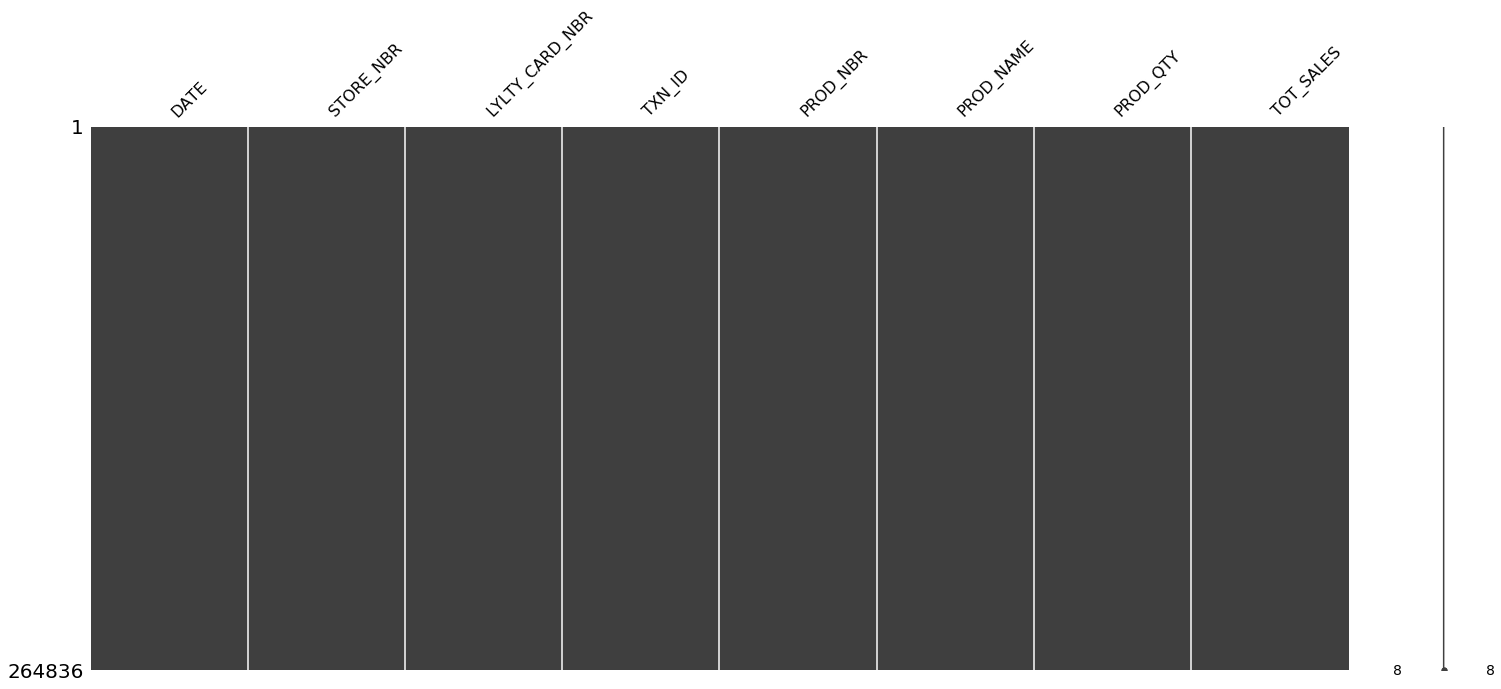

In [9]:
# Plot graph of missing values for 'transactionData'

missingno.matrix(transactionData)

# Comment: no missing numbers in transaction data 

In [11]:
# Now let's explore the features in both dataset starting with 'transactionData'

list(transactionData.columns)

['DATE',
 'STORE_NBR',
 'LYLTY_CARD_NBR',
 'TXN_ID',
 'PROD_NBR',
 'PROD_NAME',
 'PROD_QTY',
 'TOT_SALES']

In [12]:
transactionData['DATE'].head()

0    43390
1    43599
2    43605
3    43329
4    43330
Name: DATE, dtype: int64

In [13]:
# 'Date' is not in the right format

# Function that converts Excel integer into yyyy-mm-dd format
def xlseriesdate_to_datetime(xlserialdate):
    excel_anchor = datetime.datetime(1900, 1, 1)
    if(xlserialdate < 60):
        delta_in_days = datetime.timedelta(days = (xlserialdate - 1))
    else:
        delta_in_days = datetime.timedelta(days = (xlserialdate - 2))
    converted_date = excel_anchor + delta_in_days
    return converted_date

In [14]:
# Apply function to 'DATE' feature in 'transactionData' dataset

transactionData['DATE'] = transactionData['DATE'].apply(xlseriesdate_to_datetime)

In [15]:
# Check the first 5 rows of the new feature

transactionData['DATE'].head()

0   2018-10-17
1   2019-05-14
2   2019-05-20
3   2018-08-17
4   2018-08-18
Name: DATE, dtype: datetime64[ns]

In [16]:
transactionData.head()

,DATE,STORE_NBR,LYLTY_CARD_NBR,TXN_ID,PROD_NBR,PROD_NAME,PROD_QTY,TOT_SALES
0,2018-10-17,1,1000,1,5,Natural Chip Compny SeaSalt175g,2,6.0
1,2019-05-14,1,1307,348,66,CCs Nacho Cheese 175g,3,6.3
2,2019-05-20,1,1343,383,61,Smiths Crinkle Cut Chips Chicken 170g,2,2.9
3,2018-08-17,2,2373,974,69,Smiths Chip Thinly S/Cream&Onion 175g,5,15.0
4,2018-08-18,2,2426,1038,108,Kettle Tortilla ChpsHny&Jlpno Chili 150g,3,13.8


In [17]:
# Let's move on to 'PROD_NAME' feature

transactionData['PROD_NAME'].head()

0      Natural Chip        Compny SeaSalt175g
1                    CCs Nacho Cheese    175g
2      Smiths Crinkle Cut  Chips Chicken 170g
3      Smiths Chip Thinly  S/Cream&Onion 175g
4    Kettle Tortilla ChpsHny&Jlpno Chili 150g
Name: PROD_NAME, dtype: object

In [18]:
# Extract weights out of 'PROD_NAME'

transactionData['PACK_SIZE'] = transactionData['PROD_NAME'].str.extract("(\d+)")
transactionData['PACK_SIZE'] = pd.to_numeric(transactionData['PACK_SIZE'])
transactionData['PACK_SIZE'].head()

0    175
1    175
2    170
3    175
4    150
Name: PACK_SIZE, dtype: int64

In [19]:
# Create text cleaning function for 'PROD_NAME' feature

def clean_text(text):
    text = re.sub('[&/]', ' ', text) # remove special characters '&' and '/'
    text = re.sub('\d\w*', ' ', text) # remove product weights
    return text

# Apply text cleaning function to 'PROD_NAME' column

transactionData['PROD_NAME'] = transactionData['PROD_NAME'].apply(clean_text)

In [20]:
# Create one giant string and apply 'word_tokenize' to separate the words

prod_clean = transactionData['PROD_NAME']
string = ''.join(prod_clean)
prod_words = word_tokenize(string)

In [21]:
# Apply 'fdist' function which computes the frequency of each token and put it into a dataframe

word_freq = fdist(prod_words)
freq_df = pd.DataFrame(list(word_freq.items()), columns = ["Word","Frequency"]).sort_values(by = 'Frequency', ascending = False)

In [22]:
# Let's see the top 5 most frequent words

freq_df.head(10)

,Word,Frequency
10,Chips,49770
16,Kettle,40739
7,Smiths,28572
6,Cheese,27890
66,Pringles,24743
28,Salt,24719
34,Doritos,24650
8,Crinkle,23960
35,Corn,22063
48,Original,21560


In [65]:
# Drop rows with 'salsa' in 'PROD_NAME'

transactionData['PROD_NAME'] = transactionData['PROD_NAME'].apply(lambda x: x.lower())
transactionData = transactionData[~transactionData['PROD_NAME'].str.contains("salsa")]
transactionData['PROD_NAME'] = transactionData['PROD_NAME'].apply(lambda x: x.title())

In [66]:
# Let's have a look at our data table again

transactionData.head()

,DATE,STORE_NBR,LYLTY_CARD_NBR,TXN_ID,PROD_NBR,PROD_NAME,PROD_QTY,TOT_SALES,PACK_SIZE,BRAND
0,2018-10-17,1,1000,1,5,Natural Chip Compny Seasalt,2,6.0,175,Natural
1,2019-05-14,1,1307,348,66,Ccs Nacho Cheese,3,6.3,175,CCs
2,2019-05-20,1,1343,383,61,Smiths Crinkle Cut Chips Chicken,2,2.9,170,Smiths
3,2018-08-17,2,2373,974,69,Smiths Chip Thinly S Cream Onion,5,15.0,175,Smiths
4,2018-08-18,2,2426,1038,108,Kettle Tortilla Chpshny Jlpno Chili,3,13.8,150,Kettle


In [25]:
# We shall explore 'PROD_QTY' and 'TOT_SALES' feature next

transactionData['PROD_QTY'].value_counts()

# Max of 200 looks odd

2      220070
1       25476
5         415
3         408
4         371
200         2
Name: PROD_QTY, dtype: int64

In [26]:
# We have two occurrences of 200 in the dataset
# Let's explore further

transactionData.loc[transactionData['PROD_QTY'] == 200]

,DATE,STORE_NBR,LYLTY_CARD_NBR,TXN_ID,PROD_NBR,PROD_NAME,PROD_QTY,TOT_SALES,PACK_SIZE
69762,2018-08-19,226,226000,226201,4,dorito corn chp supreme,200,650.0,380
69763,2019-05-20,226,226000,226210,4,dorito corn chp supreme,200,650.0,380


In [27]:
# Both these transactions have been made by the same person at the same store
# Let's see all the transactions this person has made by tracking his loyalty card number '226000'

transactionData.loc[transactionData['LYLTY_CARD_NBR'] == 226000]

,DATE,STORE_NBR,LYLTY_CARD_NBR,TXN_ID,PROD_NBR,PROD_NAME,PROD_QTY,TOT_SALES,PACK_SIZE
69762,2018-08-19,226,226000,226201,4,dorito corn chp supreme,200,650.0,380
69763,2019-05-20,226,226000,226210,4,dorito corn chp supreme,200,650.0,380


In [28]:
# This person only made two transactions over the entire year so unlikely to be a retail customer 
# He or she is most likely purchasing for commercial purposes
# Safe to drop these this customer in both 'transactionData' and 'customerData' dataset

transactionData.drop(transactionData.index[transactionData['LYLTY_CARD_NBR'] == 226000], inplace = True)
customerData.drop(customerData.index[customerData['LYLTY_CARD_NBR'] == 226000], inplace = True)

In [29]:
# Now let's examine the number of transactions over time to see if there are any obvious data issues e.g. missing data

transactionData['DATE'].nunique()

364

In [30]:
# Look for the missing date 
# Turns out that it was Christmas Day so it makes sense because most retail stores are closed on that day

pd.date_range(start = '2018-07-01', end = '2019-06-30').difference(transactionData['DATE'])

DatetimeIndex(['2018-12-25'], dtype='datetime64[ns]', freq=None)

In [31]:
# Create a new dataframe which contains the the number of chips sold for each date

a = pd.pivot_table(transactionData, values = 'PROD_QTY', index = 'DATE', aggfunc = 'sum')
a.head()

,PROD_QTY
DATE,
2018-07-01,1273
2018-07-02,1251
2018-07-03,1296
2018-07-04,1286
2018-07-05,1258


In [32]:
b = pd.DataFrame(index = pd.date_range(start = '2018-07-01', end = '2019-06-30'))
b['PROD_QTY'] = 0
b

,PROD_QTY
2018-07-01,0
2018-07-02,0
2018-07-03,0
2018-07-04,0
2018-07-05,0
...,...
2019-06-26,0
2019-06-27,0
2019-06-28,0
2019-06-29,0


In [33]:
c = a+b
c.fillna(0, inplace = True)

In [34]:
c.head()

,PROD_QTY
2018-07-01,1273.0
2018-07-02,1251.0
2018-07-03,1296.0
2018-07-04,1286.0
2018-07-05,1258.0


In [35]:
c.index.name = 'Date'
c.rename(columns = {'PROD_QTY': 'Number of Chips Sold'}, inplace = True)
c.head() 

,Number of Chips Sold
Date,
2018-07-01,1273.0
2018-07-02,1251.0
2018-07-03,1296.0
2018-07-04,1286.0
2018-07-05,1258.0


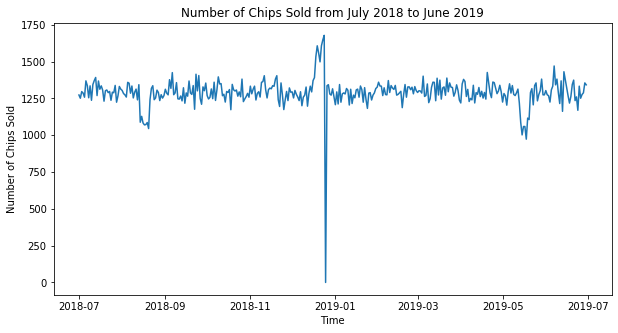

In [36]:
timeline = c.index
graph = c['Number of Chips Sold']

fig, ax = plt.subplots(figsize = (10, 5))
ax.plot(timeline, graph)

date_form = DateFormatter("%Y-%m")
ax.xaxis.set_major_formatter(date_form)
plt.title('Number of Chips Sold from July 2018 to June 2019')
plt.xlabel('Time')
plt.ylabel('Number of Chips Sold')

plt.show()

# Comment: We can see the number of chips sold spike up during the December month and zero sale on Christmas

In [37]:
# Confirm the date where sales count equals to zero

c[c['Number of Chips Sold'] == 0]

,Number of Chips Sold
Date,
2018-12-25,0.0


In [38]:
c.reset_index(inplace = True)
c.head()

,Date,Number of Chips Sold
0,2018-07-01,1273.0
1,2018-07-02,1251.0
2,2018-07-03,1296.0
3,2018-07-04,1286.0
4,2018-07-05,1258.0


In [39]:
c_december = c[(c.Date < "2019-01-01") & (c.Date > "2018-11-30")]
c_december.head()

,Date,Number of Chips Sold
153,2018-12-01,1294.0
154,2018-12-02,1253.0
155,2018-12-03,1304.0
156,2018-12-04,1278.0
157,2018-12-05,1259.0


In [40]:
# Relabel 'Date'

c_december.Date = c_december.index + 1

C:\Users\Jason Chong\anaconda3\lib\site-packages\pandas\core\generic.py:5303: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  self[name] = value


In [41]:
c_december.head()

,Date,Number of Chips Sold
153,154,1294.0
154,155,1253.0
155,156,1304.0
156,157,1278.0
157,158,1259.0


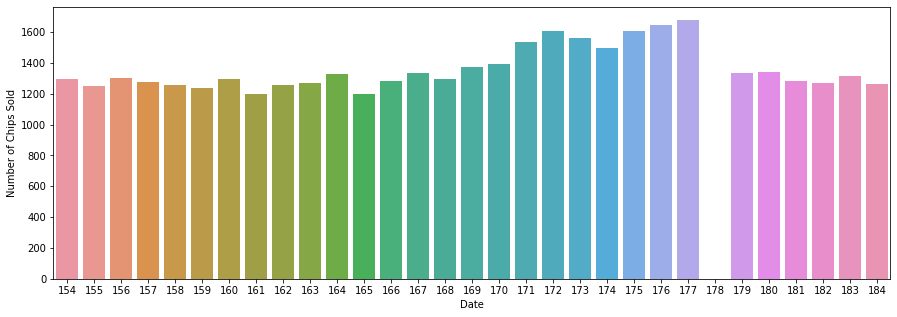

In [42]:
plt.figure(figsize = (15,5))
sns.barplot(x = 'Date', y ='Number of Chips Sold', data = c_december)

# Comment: No sales on Christmas Day (2018-12-25)

In [43]:
# Now that we are satisfied that the data no longer has outliers
# We can move on to creating other features
# At the beginning, we have already created a 'pack_size' feature
# Let's have a look again

transactionData['PACK_SIZE'].head()

0    175
1    175
2    170
3    175
4    150
Name: PACK_SIZE, dtype: int64

In [44]:
transactionData['PACK_SIZE'].unique()

# Comment: the largest size is 380g and the smallest size is 70g which seems reasonable

array([175, 170, 150, 330, 210, 270, 220, 125, 110, 134, 380, 180, 165,
       135, 250, 200, 160, 190,  90,  70], dtype=int64)

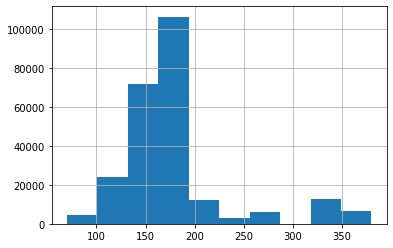

In [151]:
# Check the distribution of 'PACK_SIZE'

transactionData['PACK_SIZE'].hist()

In [50]:
# Extract brand name from 'PROD_NAME' 
# Create a new column under 'TransactionData' called 'brand'

part = transactionData['PROD_NAME'].str.partition()
transactionData['BRAND'] = part[0]
transactionData['BRAND'].head()

0    natural
1        ccs
2     smiths
3     smiths
4     kettle
Name: BRAND, dtype: object

In [52]:
transactionData['BRAND'].unique()

array(['natural', 'ccs', 'smiths', 'kettle', 'grain', 'doritos',
       'twisties', 'ww', 'thins', 'burger', 'ncc', 'cheezels', 'infzns',
       'red', 'pringles', 'dorito', 'infuzions', 'smith', 'grnwves',
       'tyrrells', 'cobs', 'french', 'rrd', 'tostitos', 'cheetos',
       'woolworths', 'snbts', 'sunbites'], dtype=object)

In [190]:
# It looks like there are duplicates of the same brand e.g. 'ww' and 'woolworths', 'red' and 'rrd', 'natural' and 'ncc', 
# 'infuzions' and 'infzns', 'snbts' and 'sunbites', 'grain' and 'grnwves', 'smiths' and 'smith', 'doritos' and 'dorito'
# Let's rename them for consistency

transactionData['BRAND'].replace(['natural', 'ncc'], 'Natural', inplace = True)
transactionData['BRAND'].replace('ccs', 'CCS', inplace = True)
transactionData['BRAND'].replace(['smiths', 'smith'], 'Smiths', inplace = True)
transactionData['BRAND'].replace('kettle', 'Kettle', inplace = True)
transactionData['BRAND'].replace(['grain', 'grnwves'], 'Natural', inplace = True)
transactionData['BRAND'].replace(['doritos', 'dorito'], 'Doritos', inplace = True)
transactionData['BRAND'].replace('twisties', 'Twisties', inplace = True)
transactionData['BRAND'].replace(['ww', 'woolworths'], 'Woolworths', inplace = True)
transactionData['BRAND'].replace('thins', 'Thins', inplace = True)
transactionData['BRAND'].replace('burger', 'Burger Rings', inplace = True)
transactionData['BRAND'].replace('cheezels', 'Cheezels', inplace = True)
transactionData['BRAND'].replace(['infzns', 'infuzions'], 'Infuzions', inplace = True)
transactionData['BRAND'].replace(['red', 'rrd'], 'Red Rock Deli', inplace = True)
transactionData['BRAND'].replace('pringles', 'Pringles', inplace = True)
transactionData['BRAND'].replace('tyrrells', 'Tyrrells', inplace = True)
transactionData['BRAND'].replace('cobs', 'Cobs', inplace = True)
transactionData['BRAND'].replace('french', 'French Fries', inplace = True)
transactionData['BRAND'].replace('tostitos', 'Tostitos', inplace = True)
transactionData['BRAND'].replace('cheetos', 'Cheetos', inplace = True)
transactionData['BRAND'].replace(['snbts', 'sunbites'], 'Sunbites', inplace = True)

transactionData['BRAND'].unique()

array(['Natural', 'CCs', 'Smiths', 'Kettle', 'Doritos', 'Twisties',
       'Woolworths', 'Thins', 'Burger Rings', 'Cheezels', 'Infuzions',
       'Red Rock Deli', 'Pringles', 'Tyrrells', 'Cobs', 'French Fries',
       'Tostitos', 'Cheetos', 'Sunbites'], dtype=object)

In [54]:
# Which brand had the most sales?

transactionData.groupby('BRAND').TOT_SALES.sum().sort_values(ascending = False)

BRAND
Kettle           390239.8
Doritos          226329.9
Smiths           217492.0
Pringles         177655.5
Infuzions         99047.6
Natural           93935.2
Thins             88852.5
Red Rock Deli     87607.5
Twisties          81522.1
Tostitos          79789.6
Cobs              70569.8
Tyrrells          51647.4
Woolworths        41059.1
Cheezels          40029.9
CCs               18078.9
Cheetos           16884.5
Sunbites           9676.4
French Fries       7929.0
Burger Rings       6831.0
Name: TOT_SALES, dtype: float64

# Customer Data

In [55]:
# Let's move on to 'customerData' dataset now

list(customerData.columns)

['LYLTY_CARD_NBR', 'LIFESTAGE', 'PREMIUM_CUSTOMER']

In [65]:
customerData.head()

,LYLTY_CARD_NBR,LIFESTAGE,PREMIUM_CUSTOMER
0,1000,YOUNG SINGLES/COUPLES,Premium
1,1002,YOUNG SINGLES/COUPLES,Mainstream
2,1003,YOUNG FAMILIES,Budget
3,1004,OLDER SINGLES/COUPLES,Mainstream
4,1005,MIDAGE SINGLES/COUPLES,Mainstream


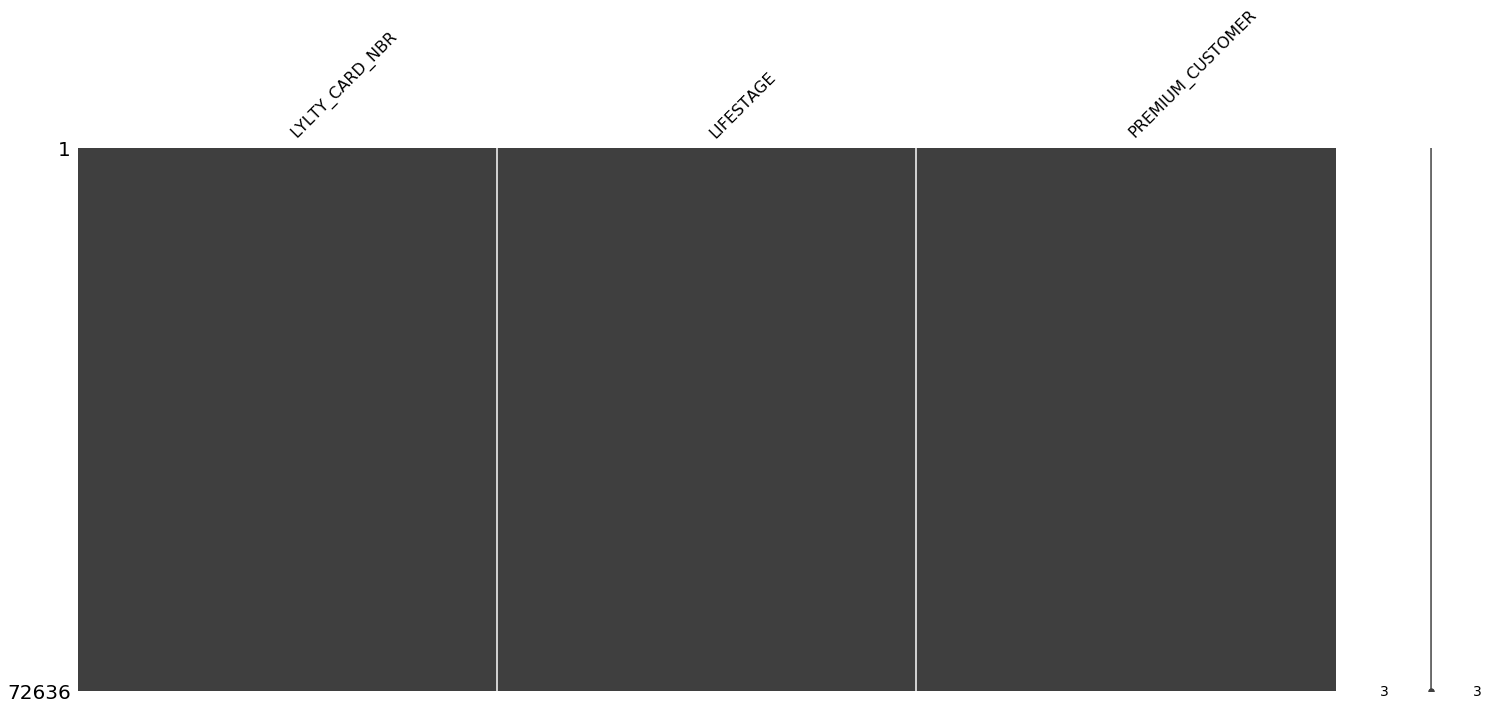

In [56]:
missingno.matrix(customerData)

In [66]:
len(customerData)

72636

In [67]:
customerData['LYLTY_CARD_NBR'].nunique()

# Comment: 'LYLTY_CARD_NBR' is unique to each row

72636

In [68]:
customerData['LIFESTAGE'].nunique()

# Comment: 7 unique lifestages of customers

7

In [69]:
# Let's see what those lifestages are

customerData['LIFESTAGE'].unique()

array(['YOUNG SINGLES/COUPLES', 'YOUNG FAMILIES', 'OLDER SINGLES/COUPLES',
       'MIDAGE SINGLES/COUPLES', 'NEW FAMILIES', 'OLDER FAMILIES',
       'RETIREES'], dtype=object)

In [70]:
# Counts for each lifestages

customerData['LIFESTAGE'].value_counts().sort_values(ascending = False)

RETIREES                  14805
OLDER SINGLES/COUPLES     14609
YOUNG SINGLES/COUPLES     14441
OLDER FAMILIES             9779
YOUNG FAMILIES             9178
MIDAGE SINGLES/COUPLES     7275
NEW FAMILIES               2549
Name: LIFESTAGE, dtype: int64

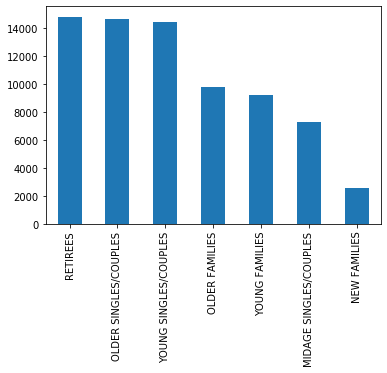

In [71]:
customerData['LIFESTAGE'].value_counts().plot(kind = 'bar')

In [72]:
# What about the 'PREMIUM_CUSTOMER' column

customerData['PREMIUM_CUSTOMER'].nunique()

3

In [73]:
# Counts for each 'PREMIUM_CUSTOMER'

customerData['PREMIUM_CUSTOMER'].value_counts().sort_values(ascending = False)

# Comment: Mainstream has the highest count, followed by budget and finally premium

Mainstream    29245
Budget        24470
Premium       18921
Name: PREMIUM_CUSTOMER, dtype: int64

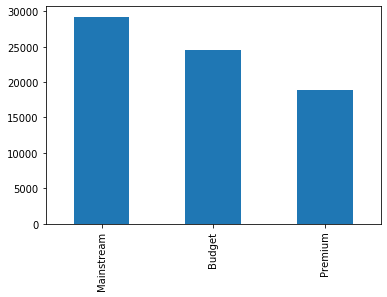

In [74]:
# Visualise 'PREMIUM_CUSTOMER'

customerData['PREMIUM_CUSTOMER'].value_counts().plot(kind = 'bar')

In [75]:
# Now let's merge the two datasets together
# Before we do, examine the shape

transactionData.shape

(246740, 11)

In [76]:
customerData.shape

(72636, 3)

In [67]:
combineData = pd.merge(transactionData, customerData)
combineData.shape

(246740, 12)

In [68]:
# The two datasets are joined together via the column 'LYLTY_CARD_NBR'

combineData.head()

,DATE,STORE_NBR,LYLTY_CARD_NBR,TXN_ID,PROD_NBR,PROD_NAME,PROD_QTY,TOT_SALES,PACK_SIZE,BRAND,LIFESTAGE,PREMIUM_CUSTOMER
0,2018-10-17,1,1000,1,5,Natural Chip Compny Seasalt,2,6.0,175,Natural,YOUNG SINGLES/COUPLES,Premium
1,2019-05-14,1,1307,348,66,Ccs Nacho Cheese,3,6.3,175,CCs,MIDAGE SINGLES/COUPLES,Budget
2,2018-11-10,1,1307,346,96,Ww Original Stacked Chips,2,3.8,160,Woolworths,MIDAGE SINGLES/COUPLES,Budget
3,2019-03-09,1,1307,347,54,Ccs Original,1,2.1,175,CCs,MIDAGE SINGLES/COUPLES,Budget
4,2019-05-20,1,1343,383,61,Smiths Crinkle Cut Chips Chicken,2,2.9,170,Smiths,MIDAGE SINGLES/COUPLES,Budget


In [69]:
# Check for null values

combineData.isnull().sum()

DATE                0
STORE_NBR           0
LYLTY_CARD_NBR      0
TXN_ID              0
PROD_NBR            0
PROD_NAME           0
PROD_QTY            0
TOT_SALES           0
PACK_SIZE           0
BRAND               0
LIFESTAGE           0
PREMIUM_CUSTOMER    0
dtype: int64

# Data analysis on customer segments

Now that our data is ready for analysis, we can define some metrics of interest to the client:

- Who spends the most on chips, describing customers by lifestage and how premium their general purchasing behaviour is
- How many customers are in each segment
- How many chips are bought per customer by segment
- What is the average chip price by customer segment
    

In [96]:
# Total sales by 'PREMIUM_CUSTOMER' and 'LIFESTAGE'

sales = pd.DataFrame(combineData.groupby(['PREMIUM_CUSTOMER', 'LIFESTAGE']).TOT_SALES.sum())
sales.rename(columns = {'TOT_SALES': 'Total Sales'}, inplace = True)
sales.sort_values(by = 'Total Sales', ascending = False, inplace = True)

In [ ]:
# Visualise

# Comment: Sales are coming from budget older families, mainstream young singles/couples and mainstream retirees

In [121]:
# Let's see if the higher sales are due to there being more customers who buy chips
# Number of customers by 'PREMIUM_CUSTOMER' and 'LIFESTAGE'
# Remember to take unique 'LYLTY_CARD_NBR'

customers = pd.DataFrame(combineData.groupby(['PREMIUM_CUSTOMER', 'LIFESTAGE']).LYLTY_CARD_NBR.nunique())
customers.rename(columns = {'LYLTY_CARD_NBR': 'Number of Customers'}, inplace = True)
customers.sort_values(by = 'Number of Customers', ascending = False).head()

Number of Customers
PREMIUM_CUSTOMER LIFESTAGE                                 
Mainstream       YOUNG SINGLES/COUPLES                 7917
                 RETIREES                              6358
                 OLDER SINGLES/COUPLES                 4858
Budget           OLDER SINGLES/COUPLES                 4849
Premium          OLDER SINGLES/COUPLES                 4682

In [ ]:
# Visualise

# Comment: There are more mainstream young singles/couples and retirees. This contributes to to more chips sales in these
# segments however this is not the major driver for the budget older families segment

In [110]:
# Higher sales may also be driven by more units of chips being bought per customer
# Let's calculate the average units per customer by 'PREMIUM_CUSTOMER' and 'LIFESTAGE'

avg_units = pd.DataFrame(combineData.groupby(['PREMIUM_CUSTOMER', 'LIFESTAGE']).PROD_QTY.mean())
avg_units.rename(columns = {'PROD_QTY': 'Average Unit per Customer'}, inplace = True)
avg_units.sort_values(by = 'Average Unit per Customer', ascending = False).head()

,,Average Unit per Customer
PREMIUM_CUSTOMER,LIFESTAGE,
Mainstream,OLDER FAMILIES,1.948795
Premium,OLDER FAMILIES,1.945496
Budget,OLDER FAMILIES,1.945384
Mainstream,YOUNG FAMILIES,1.941408
Budget,YOUNG FAMILIES,1.941226


In [ ]:
# Visualise 

# Comment: Older families and young families buy more chips per customer

In [122]:
# Let's also investigate the average price per unit chips bought for each customer segment as this is also a driver of total sales
# Total sales divided by total quantity purchased

# Average price per unit by 'PREMIUM_CUSTOMER' and 'LIFESTAGE'
avg_price = combineData.groupby(['PREMIUM_CUSTOMER', 'LIFESTAGE']).TOT_SALES.sum() / combineData.groupby(['PREMIUM_CUSTOMER', 'LIFESTAGE']).PROD_QTY.sum()
avg_price = pd.DataFrame(avg_price, columns = {'Price per Unit'})
avg_price.sort_values(by = 'Price per Unit', ascending = False).head()

# Comment: Mainstream midage and young singles and couples are more willing to pay more per packet of chips compared to their 
# budget and premium counterparts. This may be due to premium shoppers being more likely to buy healthy snacks and when
# they do buy chips, it is mainly for entertainment purposes rather than their own consumption. This is also supported by
# there being fewer premium midage and young singles and couples buying chips compared to their mainstream counterparts

Price per Unit
PREMIUM_CUSTOMER LIFESTAGE                             
Mainstream       YOUNG SINGLES/COUPLES         4.074043
                 MIDAGE SINGLES/COUPLES        3.994449
                 NEW FAMILIES                  3.935887
Budget           RETIREES                      3.932731
                 NEW FAMILIES                  3.931969

In [206]:
# As this difference in average price per unit is not too large 
# Perform an independent t-test between mainstream vs non-mainstream midage and young singles/couples

# Create a new dataframe 'pricePerUnit'
pricePerUnit = combineData

# Create a new column under 'pricePerUnit' called 'PRICE'
pricePerUnit['PRICE'] = pricePerUnit['TOT_SALES'] / pricePerUnit['PROD_QTY']

# Let's have a look
pricePerUnit.head()

,DATE,STORE_NBR,LYLTY_CARD_NBR,TXN_ID,PROD_NBR,PROD_NAME,PROD_QTY,TOT_SALES,PACK_SIZE,BRAND,LIFESTAGE,PREMIUM_CUSTOMER,price,PRICE
0,2018-10-17,1,1000,1,5,Natural Chip Compny Seasalt,2,6.0,175,Natural,YOUNG SINGLES/COUPLES,Premium,3.00,3.00
1,2019-05-14,1,1307,348,66,Ccs Nacho Cheese,3,6.3,175,CCs,MIDAGE SINGLES/COUPLES,Budget,2.10,2.10
2,2018-11-10,1,1307,346,96,Ww Original Stacked Chips,2,3.8,160,Woolworths,MIDAGE SINGLES/COUPLES,Budget,1.90,1.90
3,2019-03-09,1,1307,347,54,Ccs Original,1,2.1,175,CCs,MIDAGE SINGLES/COUPLES,Budget,2.10,2.10
4,2019-05-20,1,1343,383,61,Smiths Crinkle Cut Chips Chicken,2,2.9,170,Smiths,MIDAGE SINGLES/COUPLES,Budget,1.45,1.45


In [141]:
# Let's group our data into mainstream and non-mainstream

mainstream = pricePerUnit.loc[(pricePerUnit['PREMIUM_CUSTOMER'] == 'Mainstream') & ( (pricePerUnit['LIFESTAGE'] == 'YOUNG SINGLES/COUPLES') | (pricePerUnit['LIFESTAGE'] == 'MIDAGE SINGLES/COUPLES') ), 'PRICE']
nonMainstream = pricePerUnit.loc[(pricePerUnit['PREMIUM_CUSTOMER'] != 'Mainstream') & ( (pricePerUnit['LIFESTAGE'] == 'YOUNG SINGLES/COUPLES') | (pricePerUnit['LIFESTAGE'] == 'MIDAGE SINGLES/COUPLES') ), 'PRICE']

Text(0.5, 0, 'Price per Unit')

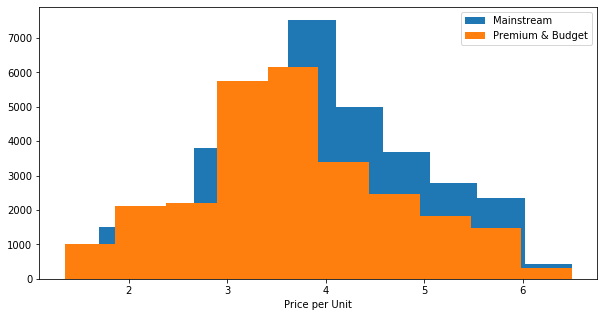

In [167]:
plt.figure(figsize = (10, 5))
plt.hist(mainstream, label = 'Mainstream')
plt.hist(nonMainstream, label = 'Premium & Budget')
plt.legend()
plt.xlabel('Price per Unit')

In [146]:
# Let's have a look at their means

[np.mean(mainstream), np.mean(nonMainstream)]

# Mainstream has a higher average price per unit

[4.039785893795137, 3.706491319963857]

In [143]:
# Perform t-test 

ttest_ind(mainstream, nonMainstream)

# Comment: Mainstream price per unit is significantly higher than non-mainstream 

Ttest_indResult(statistic=37.83196107667825, pvalue=2.235645611540966e-309)

In [170]:
# Deep dive into specific customer segment for insights
# We have found quite a few interesting insights that we can dive deeper into 
# For example, we might want to target customers segments that contribute the most to sales to retain them to further increase sales
# Let's examine mainstream young singles/couples against the rest of the cutomer segments to see if they prefer any particular brand of chips

target = combineData.loc[(combineData['LIFESTAGE'] == 'YOUNG SINGLES/COUPLES') & (combineData['PREMIUM_CUSTOMER'] == 'Mainstream'), :]
nonTarget = combineData.loc[(combineData['LIFESTAGE'] != 'YOUNG SINGLES/COUPLES' ) & (combineData['PREMIUM_CUSTOMER'] != 'Mainstream'), :]
target.head()

,DATE,STORE_NBR,LYLTY_CARD_NBR,TXN_ID,PROD_NBR,PROD_NAME,PROD_QTY,TOT_SALES,PACK_SIZE,BRAND,LIFESTAGE,PREMIUM_CUSTOMER,price
221345,2018-08-16,1,1020,26,19,Smiths Crinkle Cut Snag Sauce,1,2.6,150,Smiths,YOUNG SINGLES/COUPLES,Mainstream,2.6
221346,2018-10-02,1,1020,27,7,Smiths Crinkle Original,1,5.7,330,Smiths,YOUNG SINGLES/COUPLES,Mainstream,5.7
221347,2019-05-02,1,1020,28,84,Grnwves Plus Btroot Chilli Jam,1,3.1,180,Natural,YOUNG SINGLES/COUPLES,Mainstream,3.1
221348,2018-08-17,1,1163,188,46,Kettle Original,1,5.4,175,Kettle,YOUNG SINGLES/COUPLES,Mainstream,5.4
221349,2019-02-07,1,1163,189,12,Natural Chip Co Tmato Hrb Spce,1,3.0,175,Natural,YOUNG SINGLES/COUPLES,Mainstream,3.0


In [191]:
# Affinity to brand

# Target Segment
targetBrand = target.loc[:, ['BRAND', 'PROD_QTY']]
targetSum = targetBrand['PROD_QTY'].sum()
targetBrand['Target Brand Affinity'] = targetBrand['PROD_QTY'] / targetSum
targetBrand = pd.DataFrame(targetBrand.groupby('BRAND')['Target Brand Affinity'].sum())

# Non-target segment
nonTargetBrand = nonTarget.loc[:, ['BRAND', 'PROD_QTY']]
nonTargetSum = nonTargetBrand['PROD_QTY'].sum()
nonTargetBrand['Non-Target Brand Affinity'] = nonTargetBrand['PROD_QTY'] / nonTargetSum
nonTargetBrand = pd.DataFrame(nonTargetBrand.groupby('BRAND')['Non-Target Brand Affinity'].sum())

In [192]:
# Merge the two dataframes together

brand_proportions = pd.merge(targetBrand, nonTargetBrand, left_index = True, right_index = True)
brand_proportions.head()

,Target Brand Affinity,Non-Target Brand Affinity
BRAND,,
Burger Rings,0.002926,0.006538
CCs,0.011180,0.018445
Cheetos,0.008033,0.011759
Cheezels,0.017971,0.018904
Cobs,0.044638,0.038449


In [194]:
brand_proportions['Affinity to Brand'] = brand_proportions['Target Brand Affinity'] / brand_proportions['Non-Target Brand Affinity']
brand_proportions.sort_values(by = 'Affinity to Brand', ascending = False)

,Target Brand Affinity,Non-Target Brand Affinity,Affinity to Brand
BRAND,,,
Tyrrells,0.031553,0.025715,1.227025
Twisties,0.046184,0.037933,1.217506
Doritos,0.122761,0.101171,1.213397
Kettle,0.197985,0.166560,1.188667
Tostitos,0.045411,0.038350,1.184100
Pringles,0.119420,0.101110,1.181090
Cobs,0.044638,0.038449,1.160959
Infuzions,0.064679,0.057410,1.126622
Thins,0.060373,0.057159,1.056217


In [ ]:
# Comment: Mainstream young singles/couples are more likely to purchase Tyrrells chips compared to other brands

In [198]:
# Affinity to pack size

# Target Segment
targetSize = target.loc[:, ['PACK_SIZE', 'PROD_QTY']]
targetSum = targetSize['PROD_QTY'].sum()
targetSize['Target Pack Affinity'] = targetSize['PROD_QTY'] / targetSum
targetSize = pd.DataFrame(targetSize.groupby('PACK_SIZE')['Target Pack Affinity'].sum())

# Non-target segment
nonTargetSize = nonTarget.loc[:, ['PACK_SIZE', 'PROD_QTY']]
nonTargetSum = nonTargetSize['PROD_QTY'].sum()
nonTargetSize['Non-Target Pack Affinity'] = nonTargetSize['PROD_QTY'] / nonTargetSum
nonTargetSize = pd.DataFrame(nonTargetSize.groupby('PACK_SIZE')['Non-Target Pack Affinity'].sum())

In [200]:
# Merge the two dataframes together

pack_proportions = pd.merge(targetSize, nonTargetSize, left_index = True, right_index = True)
pack_proportions.head()

,Target Pack Affinity,Non-Target Pack Affinity
PACK_SIZE,,
70,0.003037,0.006284
90,0.006349,0.012613
110,0.106280,0.089575
125,0.003009,0.005976
134,0.119420,0.101110


In [201]:
pack_proportions['Affinity to Pack'] = pack_proportions['Target Pack Affinity'] / pack_proportions['Non-Target Pack Affinity']
pack_proportions.sort_values(by = 'Affinity to Pack', ascending = False)

,Target Pack Affinity,Non-Target Pack Affinity,Affinity to Pack
PACK_SIZE,,,
270,0.031829,0.025070,1.269608
380,0.032160,0.025711,1.250827
330,0.061284,0.050974,1.202243
110,0.106280,0.089575,1.186492
134,0.119420,0.101110,1.181090
210,0.029124,0.024891,1.170020
135,0.014769,0.012931,1.142086
250,0.014355,0.012863,1.115959
170,0.080773,0.080347,1.005300


In [202]:
# Comment: It looks like mainstream singles/couples are more likely to purchase a 270g pack size compared to other pack sizes

In [204]:
# Which brand offers 270g pack size

combineData.loc[combineData['PACK_SIZE'] == 270, :].head(10)

,DATE,STORE_NBR,LYLTY_CARD_NBR,TXN_ID,PROD_NBR,PROD_NAME,PROD_QTY,TOT_SALES,PACK_SIZE,BRAND,LIFESTAGE,PREMIUM_CUSTOMER,price
34,2019-05-18,9,9208,8634,15,Twisties Cheese,2,9.2,270,Twisties,MIDAGE SINGLES/COUPLES,Budget,4.6
79,2018-08-24,39,39167,35639,113,Twisties Chicken,2,9.2,270,Twisties,MIDAGE SINGLES/COUPLES,Budget,4.6
125,2019-05-06,54,54305,48304,15,Twisties Cheese,2,9.2,270,Twisties,MIDAGE SINGLES/COUPLES,Budget,4.6
132,2019-05-20,55,55073,48887,113,Twisties Chicken,1,4.6,270,Twisties,MIDAGE SINGLES/COUPLES,Budget,4.6
209,2019-01-01,80,80182,78980,15,Twisties Cheese,2,9.2,270,Twisties,MIDAGE SINGLES/COUPLES,Budget,4.6
252,2018-11-18,84,84096,83672,113,Twisties Chicken,2,9.2,270,Twisties,MIDAGE SINGLES/COUPLES,Budget,4.6
253,2019-05-20,88,88320,87811,113,Twisties Chicken,2,9.2,270,Twisties,MIDAGE SINGLES/COUPLES,Budget,4.6
278,2018-07-11,102,102115,102207,15,Twisties Cheese,2,9.2,270,Twisties,MIDAGE SINGLES/COUPLES,Budget,4.6
347,2019-04-05,118,118007,120735,113,Twisties Chicken,2,9.2,270,Twisties,MIDAGE SINGLES/COUPLES,Budget,4.6
350,2018-07-01,119,119051,122360,113,Twisties Chicken,2,9.2,270,Twisties,MIDAGE SINGLES/COUPLES,Budget,4.6


In [205]:
# Is Twisties the only brand who sells 270g pack size

combineData.loc[combineData['PACK_SIZE'] == 270, 'BRAND'].unique()

array(['Twisties'], dtype=object)

# Conclusion

- Sales are highest for (Budget, OLDER FAMILIES), (Mainstream, YOUNG SINGLES/COUPLES) and (Mainstream, RETIREES)
- We found that (Mainstream, YOUNG SINGLES/COUPLES) and (Mainstream, RETIREES) are mainly due to the fact that there are more customers in these segments
- (Mainstream, YOUNG SINGLES/COUPLES) are more likely to pay more per packet of chips than their premium and budget counterparts
- They are also more likely to purchase 'Tyrrells' and '270g' pack sizes than the rest of the population

# Recommendation

The category manager may consider off-locating 'Tyrrells' chips in discretionary space near segments where young singles and couples frequent to increase the visibility and impulse behaviour